## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data = load_data.load()
#data.head()

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [2]:
def check_present(row):
    bool_row = []
    for i in row:
        bool_row.append(bool(i))
    return sum(bool_row)

def check_three_of_each_type(row, cell_types=["B_cells", "T_cells"]):
    present_in_types = []
    for i in cell_types:
        cells_of_type = list(s for s in row.index if i in s)
        data_by_type = row.loc[cells_of_type]
        in_type = check_present(data_by_type)
        three_in_type = bool(in_type > 2)
        present_in_types.append(three_in_type)
    if sum(present_in_types) == len(cell_types):
        return True
    else: return False
    
indecies = data.apply(check_three_of_each_type, axis=1)
data = data[indecies]
#data.head()

Now, we normalize across runs.

Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [3]:
from scipy.stats import variation
from statistics import mean
import pandas as pd

In [4]:
cell_types = ["B_cells", "T_cells"]
CVs = {}
for population in cell_types:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1)
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/len(var)))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/len(var)))
    print (len(var))
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

B_cells
Mean CV:	 0.5615471124992008
Min CV: 	 0.06034619487725372
Max CV: 	 1.6540225433165114
Under 10%:	 2 	0.00
Under 20%:	 41 	0.06
706

T_cells
Mean CV:	 0.4738355579329681
Min CV: 	 0.05490289015036282
Max CV: 	 1.7883065149268653
Under 10%:	 11 	0.02
Under 20%:	 116 	0.16
706



This shows...


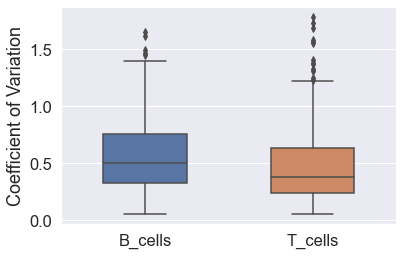

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
figure = sns.boxplot(data=CVs, width=.5
figure.set_ylabel("Coefficient of Variation")

plt.show()

Note that this data is not yet normalized, which inflates the CV values.